<a href="https://colab.research.google.com/github/yulya11/introduction_to_ai/blob/main/04_lab_dl_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4

ФИО:   
Группа:

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре (Занятие №4 очное)

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1k2MYXEp_OVQrink_XRC1PwoM0ZuNMeNz4VTWY7cI3hE/edit?usp=sharing) необходимо узнать название своего датасета
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1Phm-Fq1GL-VX7NS-DCEMRh_Fo1wU7DQ9?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

## 1. Пример импорта данных. Грузим данные

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

Датасет exams

In [13]:
data = pd.read_csv('/content/drive/MyDrive/exams.csv')

In [ ]:
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68
...,...,...,...,...,...,...,...,...
995,male,group C,high school,standard,none,73,70,65
996,male,group D,associate's degree,free/reduced,completed,85,91,92
997,female,group C,some high school,free/reduced,none,32,35,41
998,female,group C,some college,standard,none,73,74,82


Цель: Предсказать успеваемость школьников по математике, чтению и письму на основе их демографических и образовательных характеристик.

Переменные:

• Дискретные:
  * gender (пол) - Категориальная переменная с двумя значениями: мужской и женский (male, female).
  * race/ethnicity (раса/этническая принадлежность) - Категориальная переменная, разделенная на группы A-E.
  * parental level of education (уровень образования родителей) - Категориальная переменная, разделенная на категории: "неполное среднее", "среднее", "неполное высшее", "бакалавриат", "магистратура" ('high school', 'some high school', 'some college', "associate's degree", "bachelor's degree", "master's degree").
  * lunch (тип обеда) - Категориальная переменная с двумя значениями: стандартный и бесплатный (standard, free/reduced).
  * test preparation course (подготовительный курс к тесту) - Категориальная переменная с двумя значениями: завершен,  не завершен (completed, none).
  
• Непрерывные:
  * math score (баллы по математике) - Числовое значение, отражающее оценку ученика по математике.
  * reading score (баллы по чтению) - Числовое значение, отражающее оценку ученика по чтению.
  * writing score (баллы по письму) - Числовое значение, отражающее оценку ученика по письму.

Целевое событие:

• math score, reading score, writing score - дискретные переменные. Мы пытаемся предсказать целое числовое значение оценок по каждому предмету в диапазоне от 0 до 100.

Возможно, более разумным будет пытаться предсказать средний балл по всем трём дисциплинам.


## 2. Понимаем, какая перед нами задача

Так как возможные значения целевых переменных представляют собой диапазон целых чисел от 0 до 100, целесообразным будет представить эту задачу как задачу регрессии.

## 3. Делаем предобработку данных

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [ ]:
data.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,66.396000,69.002000,67.738000
std,15.402871,14.737272,15.600985
min,13.000000,27.000000,23.000000
25%,56.000000,60.000000,58.000000
50%,66.500000,70.000000,68.000000
75%,77.000000,79.000000,79.000000
max,100.000000,100.000000,100.000000


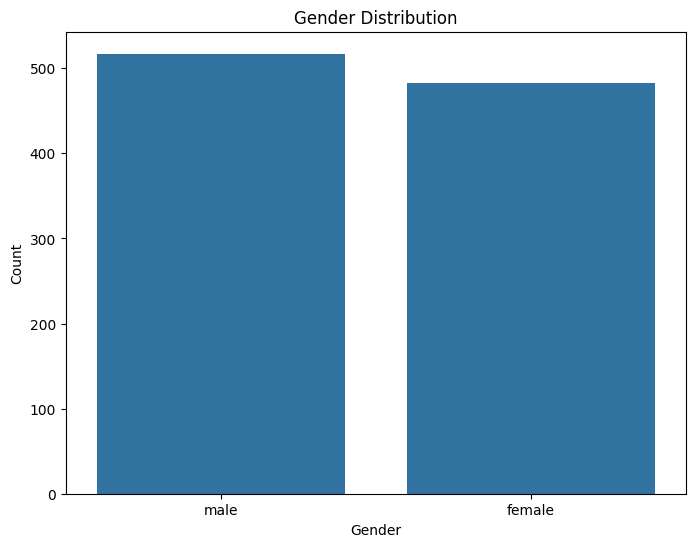

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=data)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

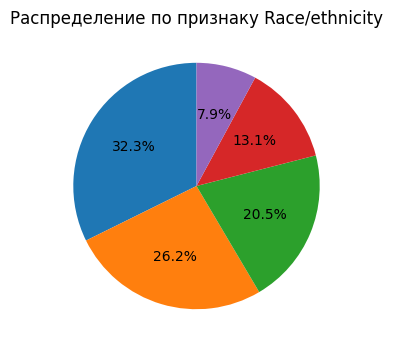

In [ ]:
plt.figure(figsize=(5, 4))
plt.pie(data['race/ethnicity'].value_counts(), autopct='%1.1f%%', startangle=90)
plt.title('Распределение по признаку Race/ethnicity')
plt.show()

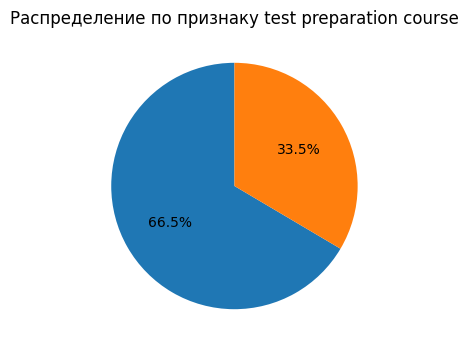

In [ ]:
plt.figure(figsize=(5, 4))
plt.pie(data['test preparation course'].value_counts(), autopct='%1.1f%%', startangle=90)
plt.title('Распределение по признаку test preparation course')
plt.show()


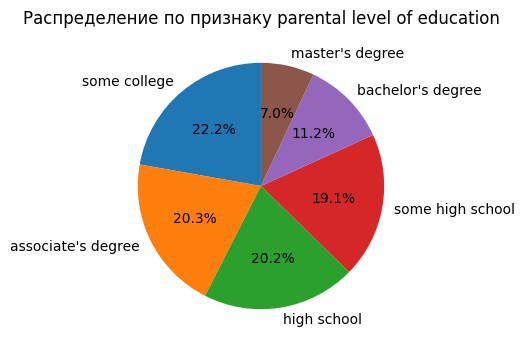

In [ ]:
plt.figure(figsize=(5, 4))
plt.pie(data['parental level of education'].value_counts(), autopct='%1.1f%%', startangle=90, labels=data['parental level of education'].value_counts().index)
plt.title('Распределение по признаку parental level of education')
plt.show()

# Распределение целевых переменных

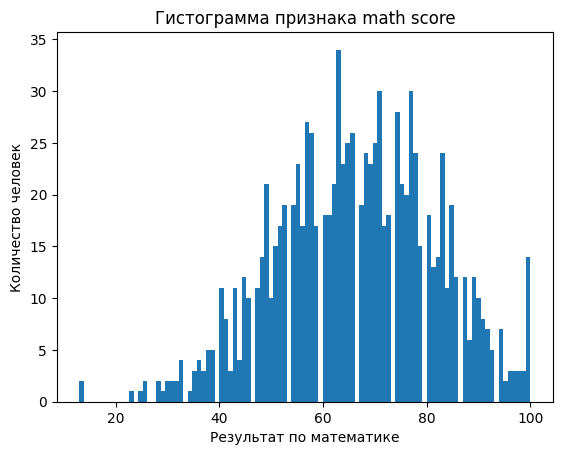

In [ ]:
plt.hist(data['math score'], bins=100)

plt.xlabel("Результат по математике")
plt.ylabel("Количество человек")

plt.title("Гистограмма признака math score")

plt.show()

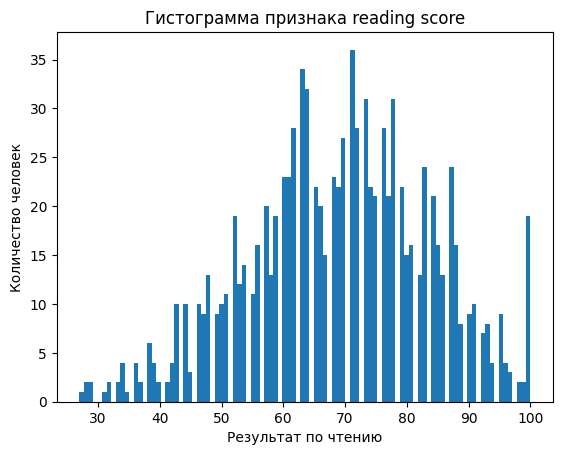

In [ ]:
plt.hist(data['reading score'], bins=100)

plt.xlabel("Результат по чтению")
plt.ylabel("Количество человек")

plt.title("Гистограмма признака reading score")

plt.show()

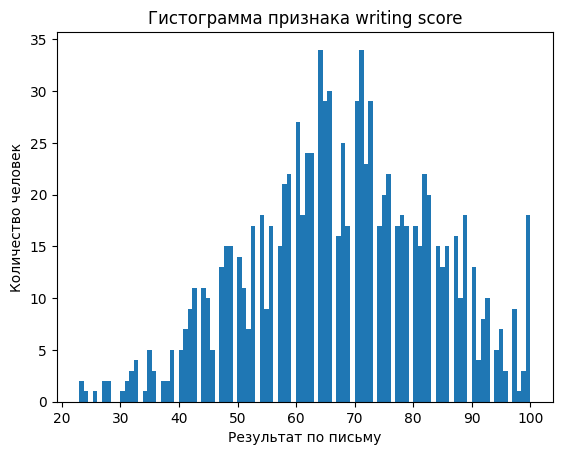

In [ ]:
plt.hist(data['writing score'], bins=100)

plt.xlabel("Результат по письму")
plt.ylabel("Количество человек")

plt.title("Гистограмма признака writing score")

plt.show()

# Пропуски

In [ ]:
data.isnull().sum()

,0
gender,0
race/ethnicity,0
parental level of education,0
lunch,0
test preparation course,0
math score,0
reading score,0
writing score,0


Пропуски отсутствуют.

# Среднее значение

<Axes: >

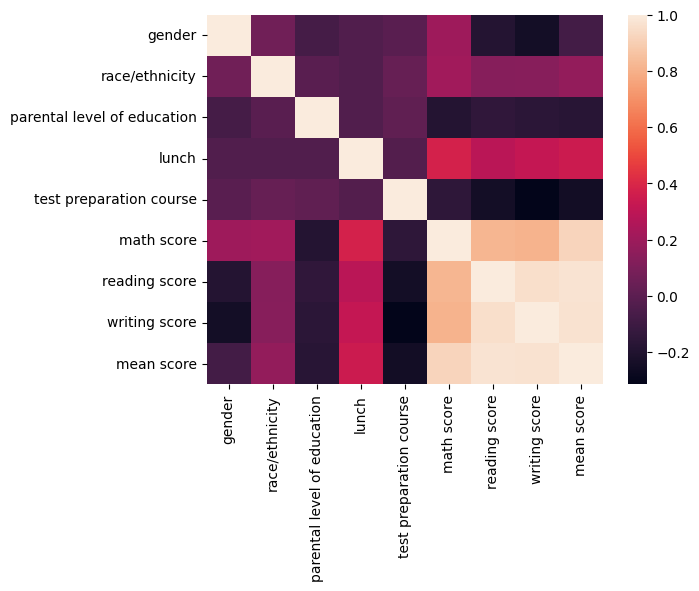

In [ ]:
# Матрица корреляций
sns.heatmap(data.corr())

In [ ]:
data['mean score'] = data[['math score', 'reading score', 'writing score']].mean(axis=1).round()
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean score
0,male,group A,high school,standard,completed,67,67,63,66.0
1,female,group D,some high school,free/reduced,none,40,59,55,51.0
2,male,group E,some college,free/reduced,none,59,60,50,56.0
3,male,group B,high school,standard,none,77,78,68,74.0
4,male,group E,associate's degree,standard,completed,78,73,68,73.0
...,...,...,...,...,...,...,...,...,...
995,male,group C,high school,standard,none,73,70,65,69.0
996,male,group D,associate's degree,free/reduced,completed,85,91,92,89.0
997,female,group C,some high school,free/reduced,none,32,35,41,36.0
998,female,group C,some college,standard,none,73,74,82,76.0


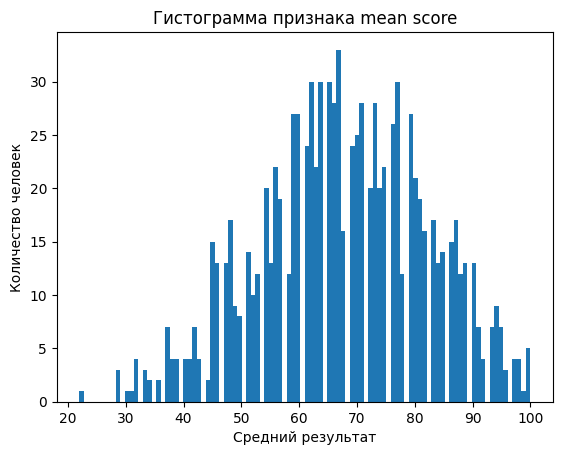

In [ ]:
plt.hist(data['mean score'], bins=100)

plt.xlabel("Средний результат")
plt.ylabel("Количество человек")

plt.title("Гистограмма признака mean score")

plt.show()

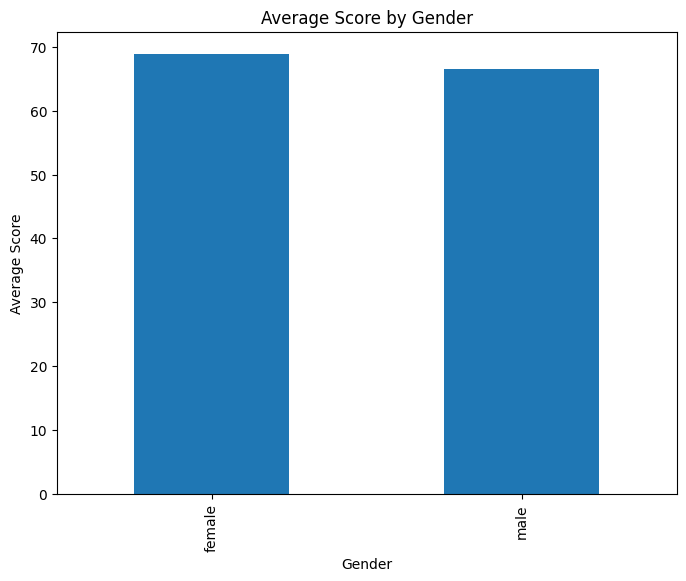

In [ ]:
grouped = data.groupby('gender')['mean score'].mean()  # Calculate mean score for each gender

plt.figure(figsize=(8, 6))
grouped.plot(kind='bar')
plt.title('Average Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Score')
plt.show()

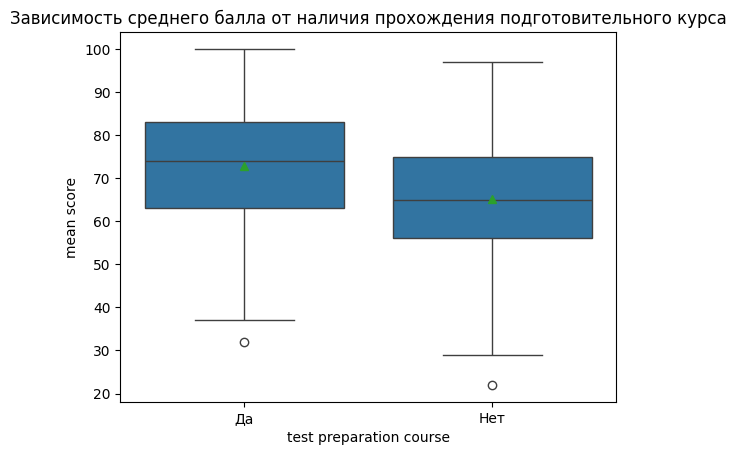

In [ ]:
sns.boxplot(x='test preparation course', y='mean score', data=data[['test preparation course','mean score']], showmeans=True)

plt.xticks(['none', 'completed'], ['Нет', 'Да'])
plt.title('Зависимость среднего балла от наличия прохождения подготовительного курса')

plt.show()

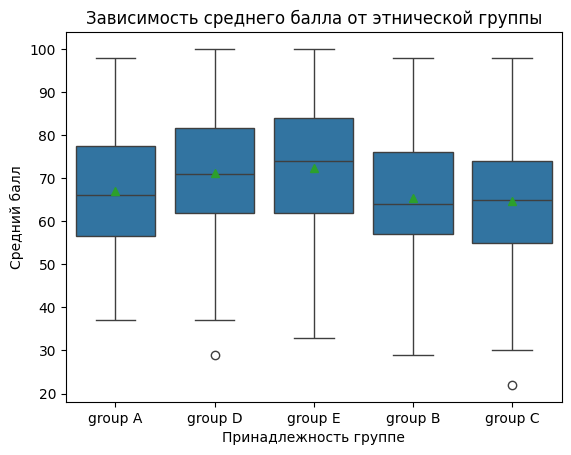

In [ ]:
sns.boxplot(x='race/ethnicity', y='mean score', data=data[['race/ethnicity','mean score']], showmeans=True)

plt.xlabel('Принадлежность группе')
plt.ylabel('Средний балл')


plt.title('Зависимость среднего балла от этнической группы')

plt.show()

In [ ]:
del data['mean score']

# Зависимости

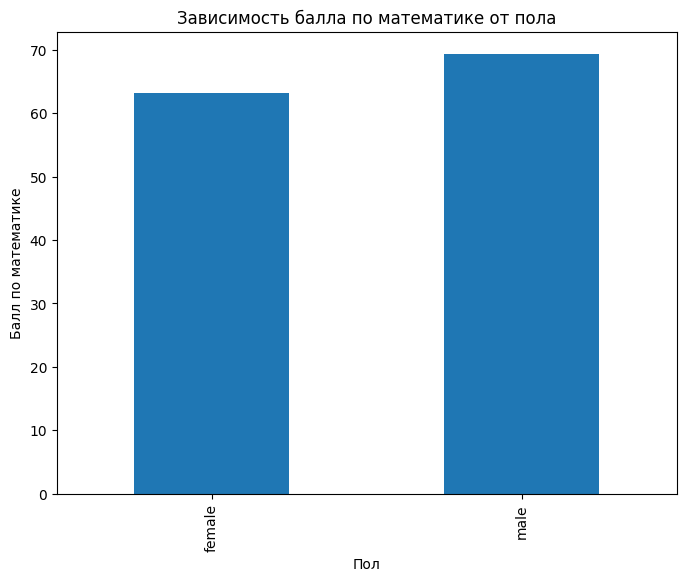

In [ ]:
grouped = data.groupby('gender')['math score'].mean()

plt.figure(figsize=(8, 6))
grouped.plot(kind='bar')
plt.title('Зависимость балла по математике от пола')
plt.xlabel('Пол')
plt.ylabel('Балл по математике')
plt.show()

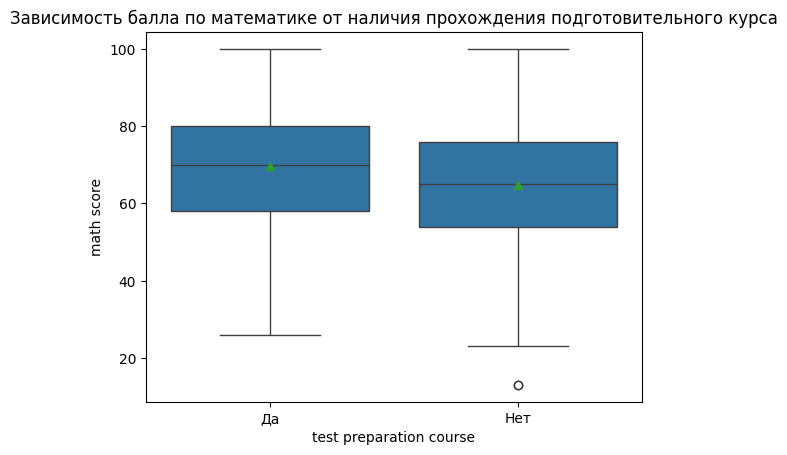

In [ ]:
sns.boxplot(x='test preparation course', y='math score', data=data[['test preparation course','math score']], showmeans=True)

plt.xticks(['none', 'completed'], ['Нет', 'Да'])
plt.title('Зависимость балла по математике от наличия прохождения подготовительного курса')

plt.show()

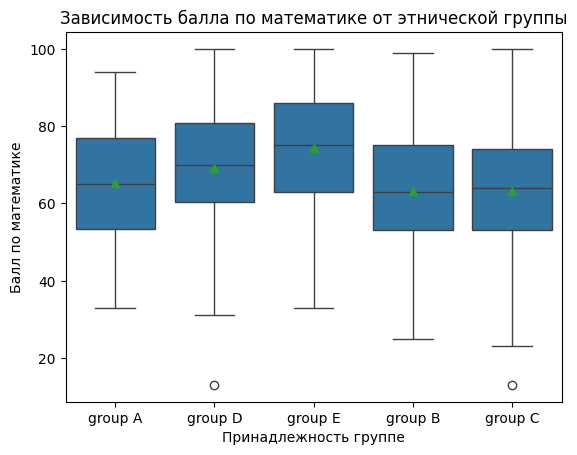

In [ ]:
sns.boxplot(x='race/ethnicity', y='math score', data=data[['race/ethnicity','math score']], showmeans=True)

plt.xlabel('Принадлежность группе')
plt.ylabel('Балл по математике')


plt.title('Зависимость балла по математике от этнической группы')

plt.show()

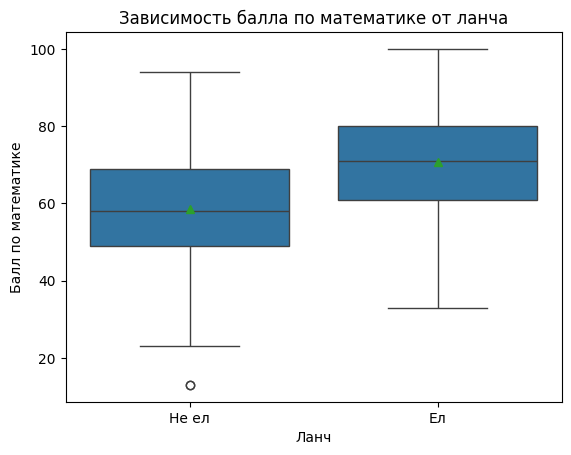

In [ ]:
sns.boxplot(x='lunch', y='math score', data=data[['lunch','math score']], showmeans=True)

plt.xlabel('Ланч')
plt.ylabel('Балл по математике')
plt.xticks(['0', '1'], ['Не ел', 'Ел'])

plt.title('Зависимость балла по математике от ланча')

plt.show()

# Нормирование числовых признаков

In [14]:
cols_to_normalize = ['reading score', 'writing score']

#минимакс нормализация
for col in cols_to_normalize:
  data[col] = (data[col] - data[col].min()) / (100 - data[col].min())

data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,0.547945,0.519481
1,female,group D,some high school,free/reduced,none,40,0.438356,0.415584
2,male,group E,some college,free/reduced,none,59,0.452055,0.350649
3,male,group B,high school,standard,none,77,0.698630,0.584416
4,male,group E,associate's degree,standard,completed,78,0.630137,0.584416
...,...,...,...,...,...,...,...,...
995,male,group C,high school,standard,none,73,0.589041,0.545455
996,male,group D,associate's degree,free/reduced,completed,85,0.876712,0.896104
997,female,group C,some high school,free/reduced,none,32,0.109589,0.233766
998,female,group C,some college,standard,none,73,0.643836,0.766234


# Закодируем категориальные признаки

In [15]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data['gender'] = labelencoder.fit_transform(data['gender'])
data['race/ethnicity'] = labelencoder.fit_transform(data['race/ethnicity'])
data['parental level of education'] = labelencoder.fit_transform(data['parental level of education'])
data['lunch'] = labelencoder.fit_transform(data['lunch'])
data['test preparation course'] = labelencoder.fit_transform(data['test preparation course'])
data.head(20)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,1,0,2,1,0,67,0.547945,0.519481
1,0,3,5,0,1,40,0.438356,0.415584
2,1,4,4,0,1,59,0.452055,0.350649
3,1,1,2,1,1,77,0.698630,0.584416
4,1,4,0,1,0,78,0.630137,0.584416
5,0,3,2,1,1,63,0.684932,0.688312
6,0,0,1,1,1,62,0.438356,0.519481
7,1,4,4,1,0,93,0.835616,0.792208
8,1,3,2,1,1,63,0.397260,0.545455
9,1,2,4,0,1,47,0.205479,0.285714


# Нейронные сети

In [43]:
class StudentScoresDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.X = torch.tensor(data.drop(columns=["math score"]).values, dtype=torch.float32)
        self.y = torch.tensor(data["math score"].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)
train_dataset = StudentScoresDataset(train_data)
test_dataset = StudentScoresDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [27]:
class Net1(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net1, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

class Net2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class Net3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x


In [37]:
def train_model(model, optimizer, criterion, epochs, train_loader, test_loader):
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item() * data.size(0)

        train_loss /= len(train_loader.dataset)
        test_loss /= len(test_loader.dataset)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return train_losses, test_losses

In [49]:
input_size = 7
hidden_size = 10
output_size = 1
epochs = 100

models = [Net1(input_size, output_size), Net2(input_size, hidden_size, output_size), Net3(input_size, hidden_size, output_size)]
optimizers = [optim.SGD(models[0].parameters(), lr=0.001), optim.Adam(models[1].parameters(), lr=0.001), optim.Adam(models[2].parameters(), lr=0.001)]
criterions = [nn.MSELoss() for _ in range(3)]

train_loss_history = []
test_loss_history = []
for model, optimizer, criterion in zip(models, optimizers, criterions):
    train_losses, test_losses = train_model(model, optimizer, criterion, epochs, train_loader, test_loader)
    train_loss_history.append(train_losses)
    test_loss_history.append(test_losses)

Epoch 1/100, Train Loss: 3519.2068, Test Loss: 2348.2274
Epoch 2/100, Train Loss: 1934.4480, Test Loss: 1398.1284
Epoch 3/100, Train Loss: 1242.3536, Test Loss: 975.5011
Epoch 4/100, Train Loss: 927.2084, Test Loss: 782.0451
Epoch 5/100, Train Loss: 776.9263, Test Loss: 687.5588
Epoch 6/100, Train Loss: 699.4738, Test Loss: 632.5901
Epoch 7/100, Train Loss: 652.1142, Test Loss: 597.5974
Epoch 8/100, Train Loss: 620.7555, Test Loss: 569.9739
Epoch 9/100, Train Loss: 595.3108, Test Loss: 547.5025
Epoch 10/100, Train Loss: 574.7556, Test Loss: 527.1398
Epoch 11/100, Train Loss: 556.0320, Test Loss: 508.7986
Epoch 12/100, Train Loss: 539.3707, Test Loss: 491.6387
Epoch 13/100, Train Loss: 523.7714, Test Loss: 476.2068
Epoch 14/100, Train Loss: 509.9026, Test Loss: 461.5027
Epoch 15/100, Train Loss: 496.2714, Test Loss: 447.6586
Epoch 16/100, Train Loss: 483.6313, Test Loss: 434.5340
Epoch 17/100, Train Loss: 471.6395, Test Loss: 422.1949
Epoch 18/100, Train Loss: 460.2967, Test Loss: 410.6

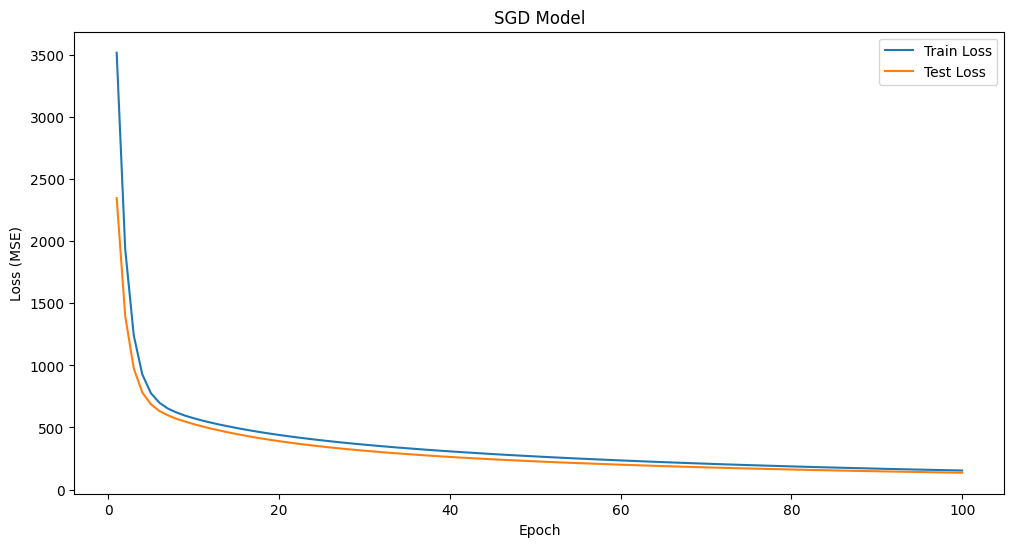

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss_history[0], label=f'Train Loss')
plt.plot(range(1, epochs + 1), test_loss_history[0], label=f'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('SGD Model')
plt.legend()
plt.show()

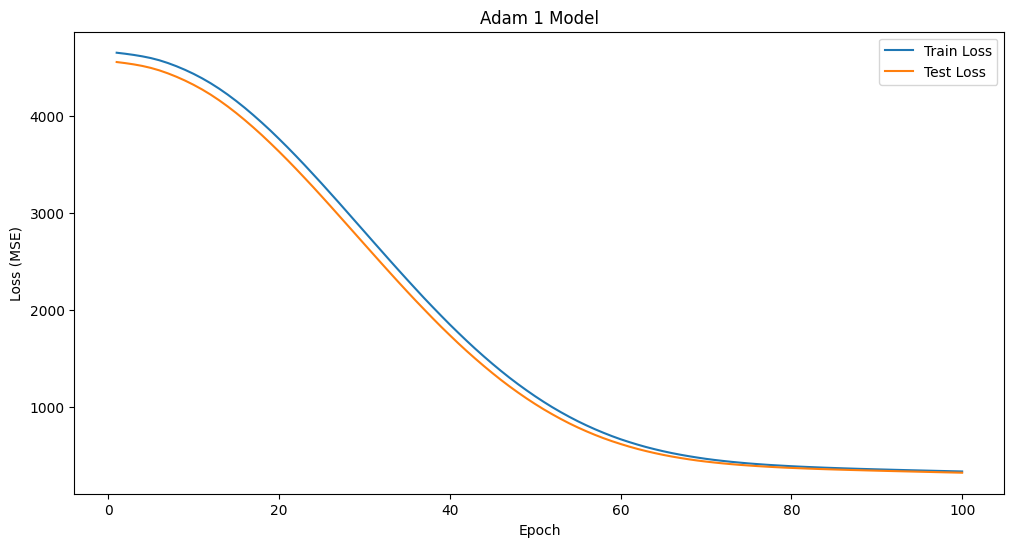

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss_history[1], label=f'Train Loss')
plt.plot(range(1, epochs + 1), test_loss_history[1], label=f'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Adam 1 Model')
plt.legend()
plt.show()

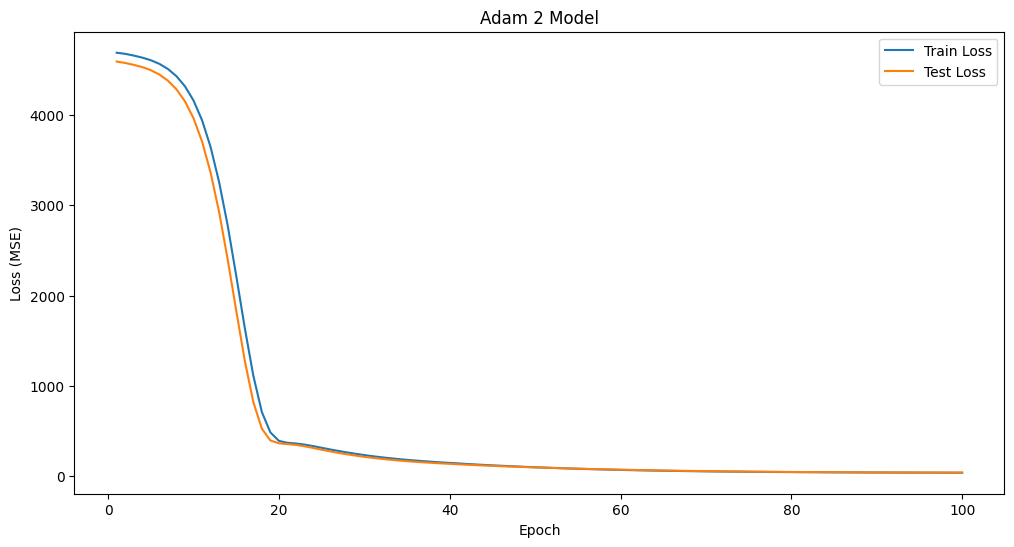

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss_history[2], label=f'Train Loss')
plt.plot(range(1, epochs + 1), test_loss_history[2], label=f'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Adam 2 Model')
plt.legend()
plt.show()

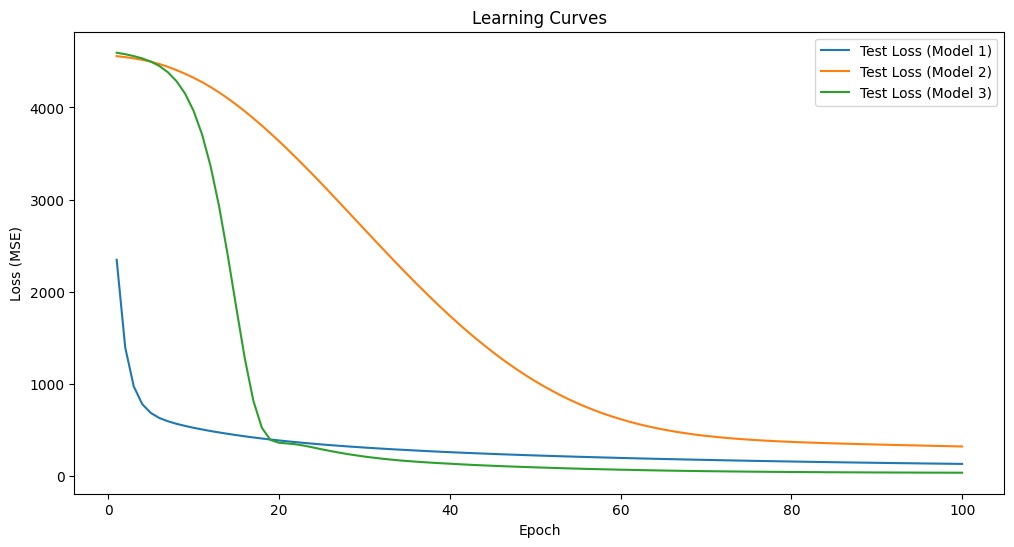

In [53]:
plt.figure(figsize=(12, 6))
for i, (train_losses, test_losses) in enumerate(zip(train_loss_history, test_loss_history)):
    plt.plot(range(1, epochs + 1), test_losses, label=f'Test Loss (Model {i+1})')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning Curves')
plt.legend()
plt.show()